<a href="https://colab.research.google.com/github/ElavarasanAJ/Spark/blob/main/spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
!tar xf spark-3.4.2-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:

# Run below command to list out the downlaoded cofing files for  the spark
!ls -a

.  ..  .config	drive  sample_data  spark-3.4.2-bin-hadoop3  spark-3.4.2-bin-hadoop3.tgz


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

In [ ]:
#initialising Spark
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,lower
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.appName('Read CSV').getOrCreate()



In [ ]:
# Check the pyspark version
import pyspark
print(pyspark.__version__)

3.4.2


In [ ]:
#Reading the src files
Goods_src = spark.read.csv('/content/drive/MyDrive/Spark/StatesUts wise Value of Goods Produced by Inmates during the year 2021.csv',header=True)
Convicts_data=spark.read.csv("/content/drive/MyDrive/Spark/Types of Indian Prison Inmates (Sex-wise) as on 31st December, 2021.csv",header=True)

In [ ]:
Goods_src.printSchema()

In [ ]:
#Renaming the column names and converting the datatype
#Filtering 1st src file out the unwanted rows and selecting the eligible columns

Selected_data=Goods_src.withColumnRenamed("Gross  Value of Sale Proceeds / Earnings (Rs. In Crore )", "Gross Value of Sale Proceeds Earnings in crores") \
.withColumn("Gross Value of Sale Proceeds Earnings in crores", col("Gross Value of Sale Proceeds Earnings in crores").cast(DoubleType())) \
                      .filter(~col("State/UT").contains("TOTAL")) \
                      .select("State/UT", "Gross Value of Sale Proceeds Earnings in crores")



In [ ]:
#Filtering 2nd src file only to have required column and converting the datatype of column and also changing its name
Selected_convicts=Convicts_data.withColumn("Total_Convicts", col("Convicts - Total").cast("int")).withColumn("State/UT_1",col("State/UT"))\
                      .filter(~lower(col("State/UT")).contains("TOTAL")) \
                      .select("State/UT_1", "Total_Convicts")

In [ ]:
#Merget two src files based on common column and dropping one of them
merged_data=Selected_data.join(Selected_convicts,Selected_data["State/UT"]==Selected_convicts["State/UT_1"]).drop("State/UT_1")

import pyspark.sql.functions as F
from pyspark.sql.types import DecimalType
#Adding a new column by diving the respective columns and multiplying them to convert in rupees
merged_data = merged_data.withColumn("Amount Contributed by Each Inmate", merged_data["Gross Value of Sale Proceeds Earnings in crores"] / merged_data["Total_Convicts"])\
.withColumn("Amount Contributed by Each Inmate",F.col("Amount Contributed by Each Inmate") * 10000000)

#changing the datatype
merged_data1=merged_data.withColumn("Amount Contributed by Each Inmate",col("Amount Contributed by Each Inmate").cast("int"))
merged_data1.show()


In [ ]:
#Sorting the states in descending order based on GDP per person
from pyspark.sql.functions import desc

Earnings=merged_data1.orderBy(desc("Amount Contributed by Each Inmate")).limit(5)
#Percapita=Earnings.withColumn("GDP Per person in Rs",F.format_number("GDP Per person in Rs",2))
Earnings.show()

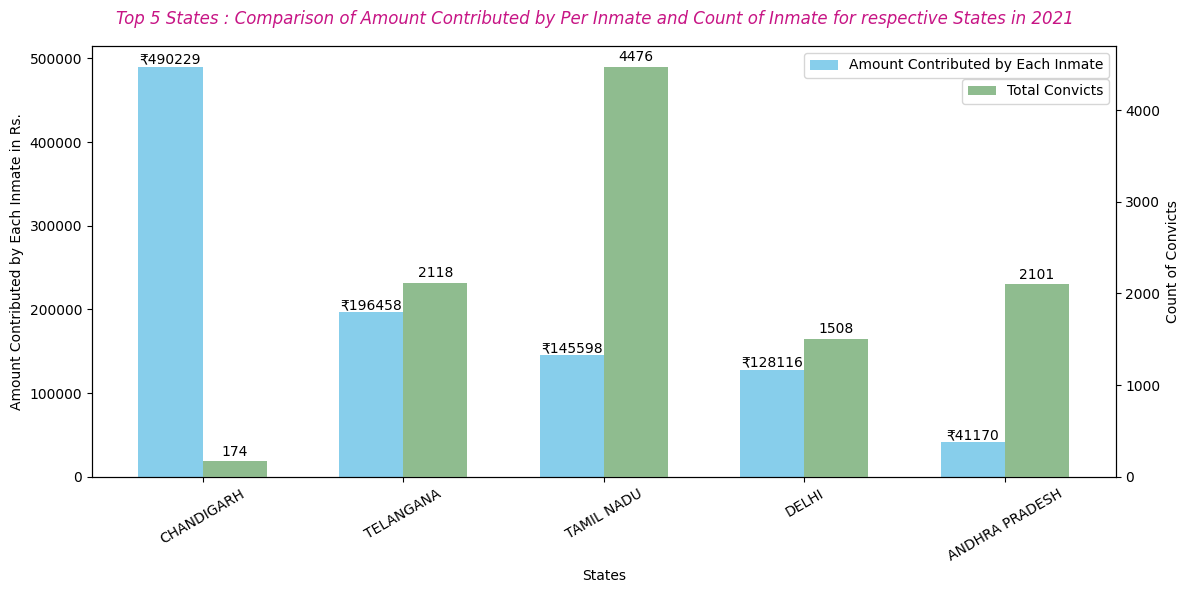

In [ ]:
import pandas as pd
import numpy as np

capita = Earnings.toPandas()
x = np.arange(len(capita['State/UT']))

bar_width=0.32
fig,ax1=plt.subplots(figsize=(12,6))

graph1=ax1.bar(x-bar_width/2,capita['Amount Contributed by Each Inmate'],width=bar_width,color='skyblue',label='Amount Contributed by Each Inmate')
ax1.set_xlabel('States')
ax1.set_ylabel("Amount Contributed by Each Inmate in Rs.")
for bar, count in zip(graph1, capita['Amount Contributed by Each Inmate']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 100, '₹{}'.format(count), ha='center', va='bottom')

ax2=ax1.twinx()
graph2=ax2.bar(x+bar_width/2,capita['Total_Convicts'],width=bar_width,color='DarkSeaGreen',label='Total Convicts')
ax2.set_ylabel("Count of Convicts")
for bar,count in zip(graph2,capita['Total_Convicts']):
  height1=bar.get_height()
  ax2.text(bar.get_x() + bar.get_width()/2, height1+100,str(count),ha='center',va='center')
ax1.tick_params(axis='x',rotation=30)

plt.xticks(x,capita['State/UT'])
#plt.legend(loc='upper left')
ax1.legend(loc='upper right',bbox_to_anchor=(1,1))
ax2.legend(loc='upper right',bbox_to_anchor=(1,0.94))

fig.suptitle("Top 5 States : Comparison of Amount Contributed by Per Inmate and Count of Inmate for respective States in 2021",color='MediumVioletRed',fontstyle='oblique')
plt.tight_layout()
plt.show()
